# Mapping LA's Public Toilets
## Kevin Liu, Paola Tirado Escareno, Carolyn Chu
## UP 229: Urban Data Science, Spring 2022

**Introduction**

In the early months of the COVID-19 shutdown, restaurants, libraries, and gas stations closed their bathroom facilities due to the unknown nature of how the virus spread. For much of the general public, finding a restroom to use while out of their home was a novel problem borne by public health response. Though for unhoused people, this challenge precedes the pandemic, and the responses by many (most) city governments have been inadequate. The City of Los Angeles initially set up [363 hand washing stations and 182 portable toilets](https://www.latimes.com/opinion/story/2021-07-25/editorial-los-angeles-homeless-bathrooms) across the city. Since then, the city has struggled with maintenance and has faced backlash when trying to remove them (see [here](https://laist.com/news/housing-homelessness/la-city-council-to-consider-reinstating-porta-potties-for-unhoused-angelenos) or [here](https://www.lataco.com/porta-potty-homeless/)). Still, access to clean, accessible restrooms remains an ongoing and dire issue for unhoused people in our communities. In this research project, we examine the access and distribution to public restrooms by comparing their locations to the 2020 Homeless Count data from L.A. County.

Our research questions include, "What's the distribution of publicly available toilets in Los Angeles and how does this compare to the distribution of unhoused people in the county? Through spatial clustering, can we find patterns in this distribution? What kinds of correlation do we find between publicly available toilets and race/ethnicity of certain census tracts?" 

**Data Preparation**

Previous to this notebook, we compiled a dataset of publicly available toilets from a variety of data sources including LACAN, Los Angeles Recreation and Parks, and the L.A. and Los Angeles County Library systems. We also joined the Los Angeles County Homeless Count Data (2020) with 5-Year American Community Survey (ACS) population counts and census tract geometries (which we acquired from the census API and LA County Open Data Portal, respectively). We bring these datsets in at the beginning of this notebook.

In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

### Import Data

In [2]:
#upload toilet data
toilets = gpd.read_file('alltoilets.geojson')
toilets.sample(10)

,name,type,branch_name,geometry
188,11545 Tuxford St,LAHSA Handwashing Station,None,POINT (-118.38326 34.22619)
148,Sherman Way & Shoup Avenue,LAHSA Handwashing Station,None,POINT (-118.61469 34.20101)
367,None,LA City Library,Studio City,POINT (-118.40560 34.15050)
16,Lake Balboa/Anthony C. Bielenson Park,LA Parks,None,POINT (-118.50101 34.18413)
154,Venice and Globe,LAHSA Handwashing Station,None,POINT (-118.41897 34.01203)
91,S Avenue 24,LAHSA Handwashing Station,None,POINT (-118.21699 34.07546)
159,Tampa Avenue & 101 FWY Underpass,LAHSA Handwashing Station,None,POINT (-118.55345 34.17356)
198,7061 Fountain Ave,LAHSA Handwashing Station,None,POINT (-118.34348 34.09434)
312,None,LA City Library,Silver Lake,POINT (-118.25960 34.10042)
28,Runnymede Park,LA Parks,None,POINT (-118.57294 34.20583)


The toilets dataset is a combination of all of the various LAHSA recorded handwashing stations, LACAN recorded handwashing stations, park bathrooms, and libraries. We code the data points by type, allowing us to later on map out the various types of hygiene stations all across the city and county.

In [3]:
#upload homeless data count
counts = gpd.read_file('homelesscount_tracts.geojson').to_crs('EPSG:4326')
counts.head()

,short_geoid,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry
0,911001,4025735684.42,9110.01,6620403.0,911001,1998891.0,06037911001,353933.808192,4087.0,30.0,"MULTIPOLYGON (((-117.66712 34.55801, -117.6671..."
1,980003,2078689856.02,9800.03,6575300.0,980003,2112006.0,06037980003,273188.86321,0.0,925.0,"MULTIPOLYGON (((-117.88061 34.76362, -117.8825..."
2,930301,11118018325.1,9303.01,6603027.0,930301,1932124.0,06037930301,628603.531323,869.0,928.0,"MULTIPOLYGON (((-117.65524 34.39722, -117.6551..."
3,573003,4824001.88224,5730.03,6500215.0,573003,1747305.0,06037573003,9050.00845755,2016.0,2.0,"MULTIPOLYGON (((-118.19923 33.79712, -118.1992..."
4,297602,6697030.7108,2976.02,6473372.0,297602,1719119.0,06037297602,12308.3153848,4005.0,64.0,"MULTIPOLYGON (((-118.28798 33.72258, -118.2879..."


The homelesscount_tracts dataset is a joined json containing both the [2020 Economic Roundtable Homeless Count by Census Tract data](https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/), and the 2019 ACS 5 Year Estimate Total Population of LA County divided by census tract. The 2020 Homeless Count data utilizes the older census tracts from the 2019 ACS 5-year as opposed to the new 2020 tracts. So, we joined the 2020 Homeless Count data with the 2019 ACS 5-year data on the census tract.

### Spatial Join of Toilets and Point in Time Count

To get a sense of how many toilets are available to each houseless person within a given census tract, we spatially join toilets and homelesscount_tracts, count the number of toilets within each census tract, and divide the houseless population in the tract by the number of toilets.

In [4]:
joinedGdf = gpd.sjoin(counts, toilets, how='left', predicate = 'intersects')
joinedGdf.head()

,short_geoid,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry,index_right,name,type,branch_name
0,911001,4025735684.42,9110.01,6620403.0,911001,1998891.0,06037911001,353933.808192,4087.0,30.0,"MULTIPOLYGON (((-117.66712 34.55801, -117.6671...",NaN,NaN,NaN,NaN
1,980003,2078689856.02,9800.03,6575300.0,980003,2112006.0,06037980003,273188.86321,0.0,925.0,"MULTIPOLYGON (((-117.88061 34.76362, -117.8825...",NaN,NaN,NaN,NaN
2,930301,11118018325.1,9303.01,6603027.0,930301,1932124.0,06037930301,628603.531323,869.0,928.0,"MULTIPOLYGON (((-117.65524 34.39722, -117.6551...",NaN,NaN,NaN,NaN
3,573003,4824001.88224,5730.03,6500215.0,573003,1747305.0,06037573003,9050.00845755,2016.0,2.0,"MULTIPOLYGON (((-118.19923 33.79712, -118.1992...",NaN,NaN,NaN,NaN
4,297602,6697030.7108,2976.02,6473372.0,297602,1719119.0,06037297602,12308.3153848,4005.0,64.0,"MULTIPOLYGON (((-118.28798 33.72258, -118.2879...",NaN,NaN,NaN,NaN


In [5]:
#check whether lengths are ok - looks reasonable
print('counts length: {}'.format(len(counts)))
print('toilets length: {}'.format(len(toilets)))
print('joinedGdf length: {}'.format(len(joinedGdf)))


counts length: 2345
toilets length: 374
joinedGdf length: 2469


In [6]:
#right join to the toilets, so drops all census tracts w/o toilets
joinedGdf2 = gpd.sjoin(counts, toilets, how='right', predicate='intersects')

In [8]:
#check that it looks correct
#joinedGdf2.head()

In [9]:
#bring back the original joinedGdf
#set index in preparation of joining n_TOILETS
joinedGdf.set_index('short_geoid', inplace=True)

In [11]:
#count the number of toilets per census tract
#creates a series
n_toilets = joinedGdf2.groupby('short_geoid').size()

#convert the series into a df
n_TOILETS=pd.DataFrame(n_toilets)

In [12]:
#rename the column to something that makes more sense
n_TOILETS.columns = ['number_toilets']

In [13]:
#join
joinedGdf3=joinedGdf.join(n_TOILETS)

In [14]:
#fill all NaN's with zero
joinedGdf3['number_toilets'] = joinedGdf3['number_toilets'].fillna(0)

In [19]:
#joinedGdf3.head()

In [16]:
#calculate a ratio of # of people per public toilet/handwashing station
joinedGdf3['toilet_ratio'] = joinedGdf3['homeless_count']/joinedGdf3['number_toilets']
joinedGdf3.head()

,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry,index_right,name,type,branch_name,number_toilets,toilet_ratio
short_geoid,,,,,,,,,,,,,,,,
101110,12295652.6944,1011.10,6473137.0,101110,1916938.0,06037101110,15083.8543322,4824.0,1463.0,"MULTIPOLYGON (((-118.29792 34.26322, -118.2969...",369.0,None,LA City Library,Sunland - Tujunga,1.0,1463.0
101122,28457712.2343,1011.22,6474004.0,101122,1919937.0,06037101122,31671.4558884,3291.0,671.0,"MULTIPOLYGON (((-118.27742 34.25990, -118.2774...",NaN,NaN,NaN,NaN,0.0,inf
101210,7003370.52469,1012.10,6473812.0,101210,1914571.0,06037101210,12066.77064,5882.0,1445.0,"MULTIPOLYGON (((-118.28592 34.25589, -118.2859...",NaN,NaN,NaN,NaN,0.0,inf
101220,7522986.29954,1012.20,6476560.0,101220,1914066.0,06037101220,12697.6262999,2902.0,1703.0,"MULTIPOLYGON (((-118.27817 34.25577, -118.2782...",NaN,NaN,NaN,NaN,0.0,inf
101300,27772933.9487,1013.00,6479771.0,101300,1913027.0,06037101300,29383.7012162,4410.0,1578.0,"MULTIPOLYGON (((-118.26526 34.25238, -118.2653...",NaN,NaN,NaN,NaN,0.0,inf


In [17]:
# Replacing all inf values in the dataframe with zero

import numpy as np
joinedGdf3 = joinedGdf3.replace([np.inf, -np.inf], 0)

### Exploring the toilet ratio

In this section, we examine our data by sorting, wrangling, and mapping.

In [28]:
#sort by census tracts with highest number of toilets
oilets_descending = joinedGdf3.sort_values(by='number_toilets',ascending = False)
toilets_descending.head(5)

,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry,index_right,name,type,branch_name,number_toilets,toilet_ratio
short_geoid,,,,,,,,,,,,,,,,
206300,6637586.94543,2063.00,6487985.0,206300,1837432.0,06037206300,13167.1657338,5514.0,403.0,"MULTIPOLYGON (((-118.23811 34.04327, -118.2382...",286.0,601 San Pedro St,Showrs & Refesh Spots,None,24.0,16.791667
206300,6637586.94543,2063.00,6487985.0,206300,1837432.0,06037206300,13167.1657338,5514.0,403.0,"MULTIPOLYGON (((-118.23811 34.04327, -118.2382...",58.0,501 San Julian St,LAHSA Handwashing Station,None,24.0,16.791667
206300,6637586.94543,2063.00,6487985.0,206300,1837432.0,06037206300,13167.1657338,5514.0,403.0,"MULTIPOLYGON (((-118.23811 34.04327, -118.2382...",38.0,5th / San Pedro,LAHSA Handwashing Station,None,24.0,16.791667
206300,6637586.94543,2063.00,6487985.0,206300,1837432.0,06037206300,13167.1657338,5514.0,403.0,"MULTIPOLYGON (((-118.23811 34.04327, -118.2382...",275.0,San Jullian between 5th and 6th,Handwashing Stations not on LAHSA Map,None,24.0,16.791667
206300,6637586.94543,2063.00,6487985.0,206300,1837432.0,06037206300,13167.1657338,5514.0,403.0,"MULTIPOLYGON (((-118.23811 34.04327, -118.2382...",36.0,East 5th Street & Crocker Street,LAHSA Handwashing Station,None,24.0,16.791667


In the lines of code and output above, we see that areas around Skid Row have highest concentrations of toilets, showers, and refresh spots. In this area, there are approximately 17 people to 1 restroom. (See toilet_ratio column.)

In [29]:
# which tracts had the highest ratio of houseless people per toilet
ratio_descending = joinedGdf3.sort_values(by='toilet_ratio',ascending = False)
ratio_descending.head(3) #chose 3 to shorten the length of this notebook


,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry,index_right,name,type,branch_name,number_toilets,toilet_ratio
short_geoid,,,,,,,,,,,,,,,,
181400,9463037.10995,1814.00,6498460.0,181400,1872203.0,06037181400,14429.0461216,4619.0,2331.0,"MULTIPOLYGON (((-118.20150 34.13956, -118.2015...",331.0,None,LA City Library,Eagle Rock,1.0,2331.0
188100,22871279.8937,1881.00,6479617.0,188100,1872185.0,06037188100,26027.2297326,3761.0,2258.0,"MULTIPOLYGON (((-118.27556 34.15317, -118.2755...",20.0,North Atwater Park,LA Parks,None,1.0,2258.0
218110,6443242.09396,2181.10,6462438.0,218110,1838675.0,06037218110,12758.8563101,3476.0,2256.0,"MULTIPOLYGON (((-118.32670 34.04782, -118.3255...",303.0,None,LA City Library,Washington Irving,1.0,2256.0


In [30]:
ratio_ascending = joinedGdf3.sort_values(by='toilet_ratio',ascending = True)
ratio_ascending.head(3) #chose 3 to shorten the length of this notebook


,shape_area,label,x_center,ct10,y_center,geoid10,shape_len,total_pop,homeless_count,geometry,index_right,name,type,branch_name,number_toilets,toilet_ratio
short_geoid,,,,,,,,,,,,,,,,
403000,26031458.9794,4030.00,6635225.0,403000,1836115.0,06037403000,25904.9008688,7118.0,895.0,"MULTIPOLYGON (((-117.74965 34.04421, -117.7495...",NaN,NaN,NaN,NaN,0.0,0.0
503502,13395511.3668,5035.02,6560697.0,503502,1797646.0,06037503502,17898.4837216,4154.0,1773.0,"MULTIPOLYGON (((-117.99310 33.93352, -117.9930...",NaN,NaN,NaN,NaN,0.0,0.0
503601,15017905.8961,5036.01,6558278.0,503601,1794182.0,06037503601,16783.5134451,4245.0,1774.0,"MULTIPOLYGON (((-118.00351 33.92308, -118.0034...",NaN,NaN,NaN,NaN,0.0,0.0


Most census tracts have 0-1 toilet in the entire tract. Therefore, we're seeing ratios of 0 toilets per 7,000+ unhoused people, or 2331 unhoused people to 1 toilet (in Eagle Rock, for example). However, we can likely assume that unhoused people in these tracts are likely using some publicly available restrooms elsewhere (in addition to using public streets, alleys, or other public spaces as restrooms). This illustrates one of our key limitations: our dataset of publicly available restrooms is not comprehensive.

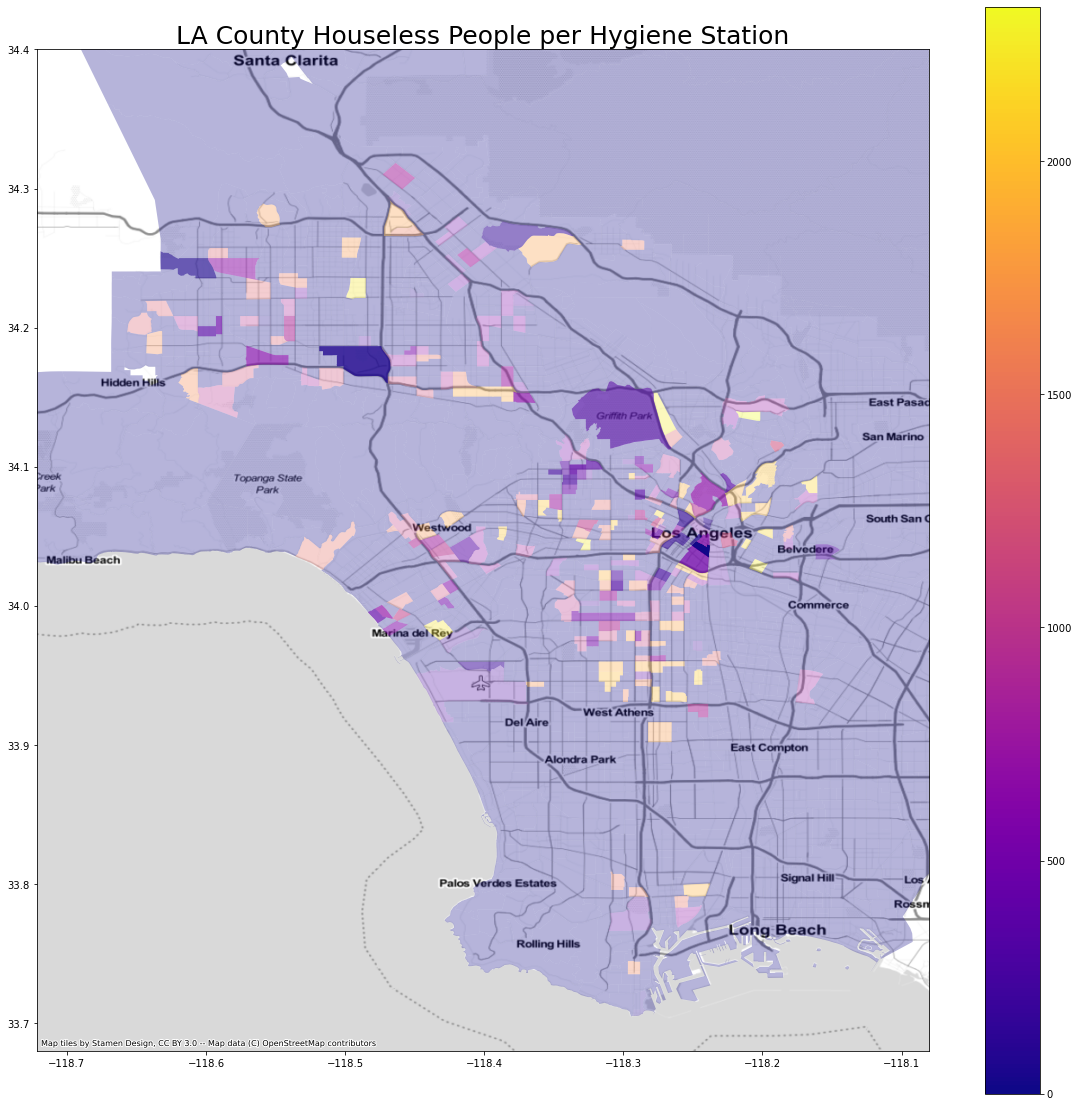

In [31]:
# Mapping
import matplotlib.pyplot as plt
import contextily as ctx

#LA county wide map

f, ax = plt.subplots(figsize=(20,20))

joinedGdf3.plot('toilet_ratio', 
            ax=ax, 
            cmap='plasma', 
            legend=True, 
            legend_kwds={'orientation': 'vertical'}, 
            alpha=0.3, 
            label='Count')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])
ax.set_title('LA County Houseless People per Hygiene Station', fontsize=25)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

### Exploring the datasets spatially

We also wanted to overlay the toilets data with the number of houseless individuals per census tract, with the aim at identifying certain tracts that have high houseless populations and a lack of hygiene stations available.

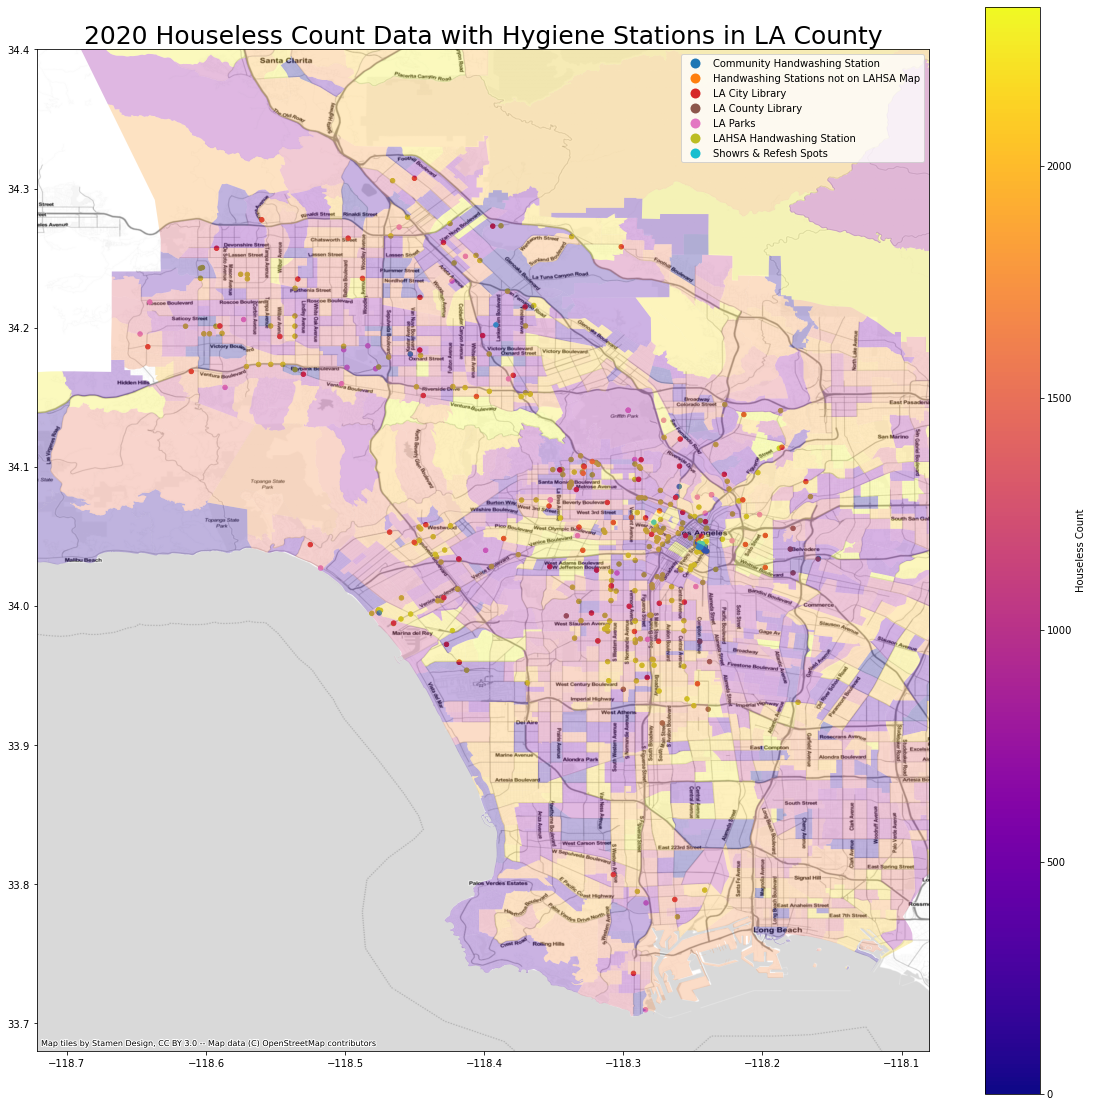

In [40]:
#LA county wide map
import contextily as ctx
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='plasma', 
            legend=True, 
            legend_kwds={'orientation':'vertical', 'label':'Houseless Count'}, 
            alpha=0.3, 
            label='Count')
ax.set_xlim([-118.721783, -118.08]) 
ax.set_ylim([33.68, 34.4])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in LA County', fontsize=25)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite, zoom=12)

plt.show()

First, we take a wider look at all of the parts of LA County where our data is represented. We leave out the Antelope Valley and Catalina because we don't have any hygiene station data from those areas. <br>
<br>
Just from this zoomed out view of the datasets, we see that the tracts with the largest houseless populations are sprinkled throughout the County without any readily identifiable trends at first glance. We see some tracts with high houseless populations in the San Fernando Valley, particularly in the southern side up against the Studio City area. It seems that the most high concentration tracts occur throughout Central Los Angeles, Downtown LA, and the Mid City area, but also some parts of Culver-West and Westchester.<br>
<br>
To get an idea of how the toilets dataset looks countywide, we also conduct some spatial clustering below.

In [41]:
gdf = toilets

[]

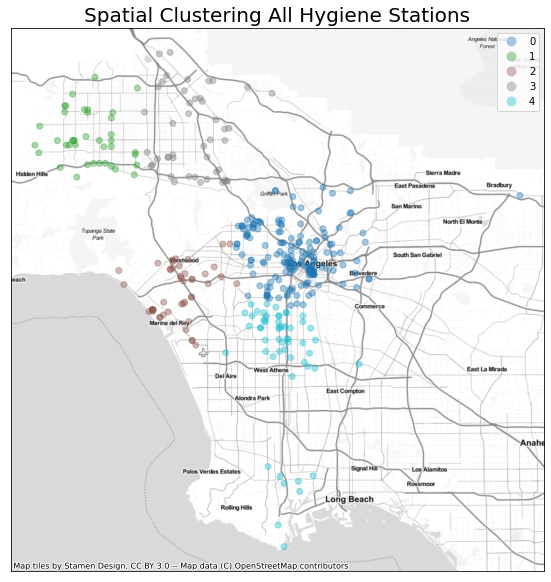

In [48]:
# Splitting out our geoemtry column into separate lat long columns

gdf['lon'] = gdf.geometry.apply(lambda p: p.x)
gdf['lat'] = gdf.geometry.apply(lambda p: p.y)

# Running kmeans to create the cluster_id column based on the lat long
# Selecting 5 clusters to begin with, knowing that we have around 5-6 different concentrations of data

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=1).fit(gdf[['lat','lon']])
gdf['cluster_id'] = kmeans.labels_

# Plotting

fig, ax = plt.subplots(figsize=(10,10))
gdf.to_crs('EPSG:3857').plot('cluster_id', categorical=True, legend=True, 
                                   ax=ax, alpha=0.4)

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Spatial Clustering All Hygiene Stations', fontsize=20)                           

ax.set_xticks([])
ax.set_yticks([])

It looks like the clusters breakdown as:

0 - Central & East LA <br>
1 - West San Fernando Valley <br>
2 - West LA <br>
3 - East San Fernando Valley <br>
4 - South LA and South Bay
<br>


Seeing as we have some clear clusters around Central and East LA and the San Fernando Valley, let's take a closer look at each of these neighborhoods

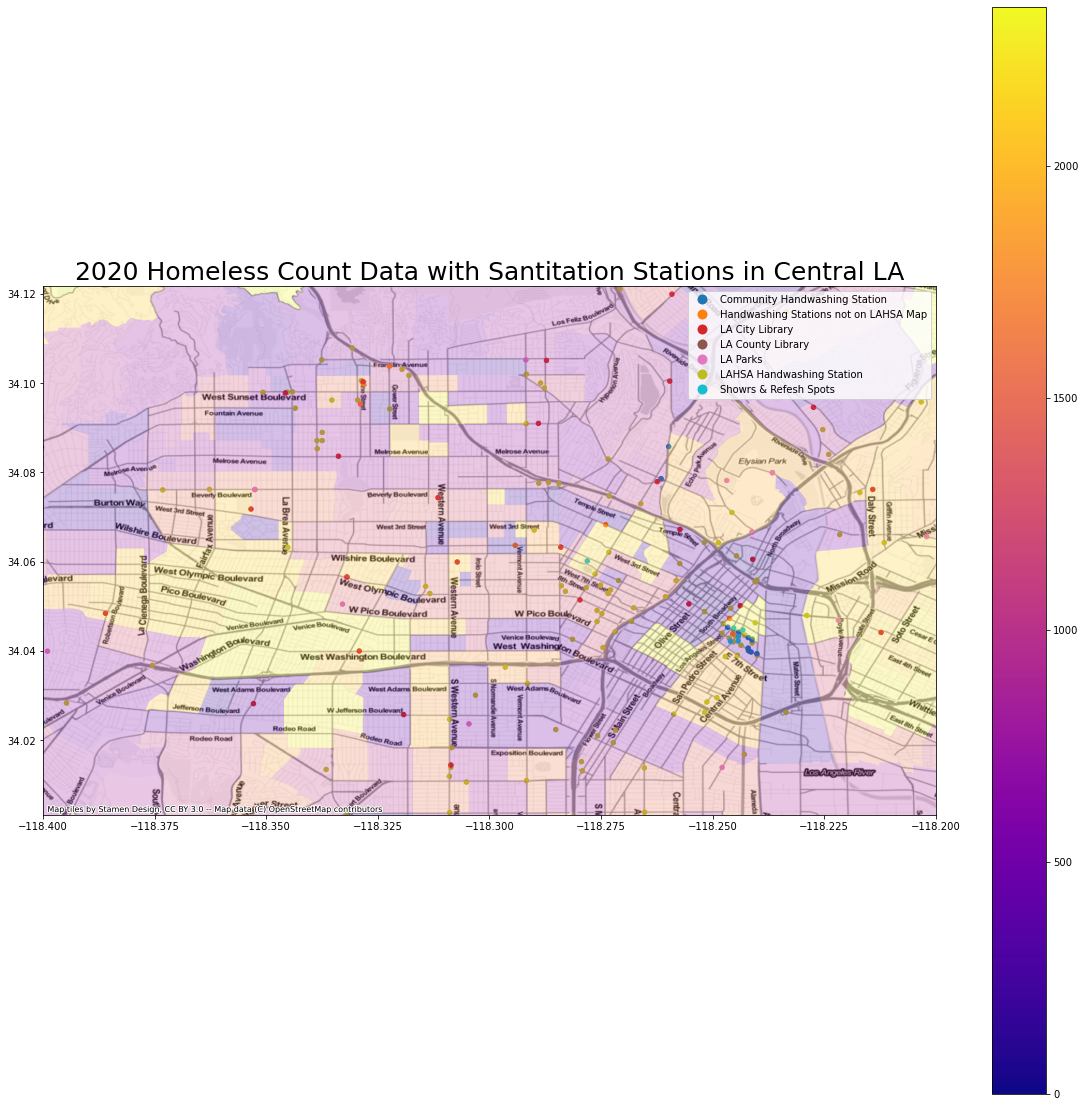

In [62]:
# Central LA specific map

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='plasma', 
            legend=True, 
            legend_kwds={'orientation': 'vertical'}, 
            alpha=0.25, 
            label='Count')
ax.set_xlim([-118.40, -118.20]) 
ax.set_ylim([34.003307, 34.121767])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in Central LA', fontsize=25)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()


Some text here with findings (WIP)

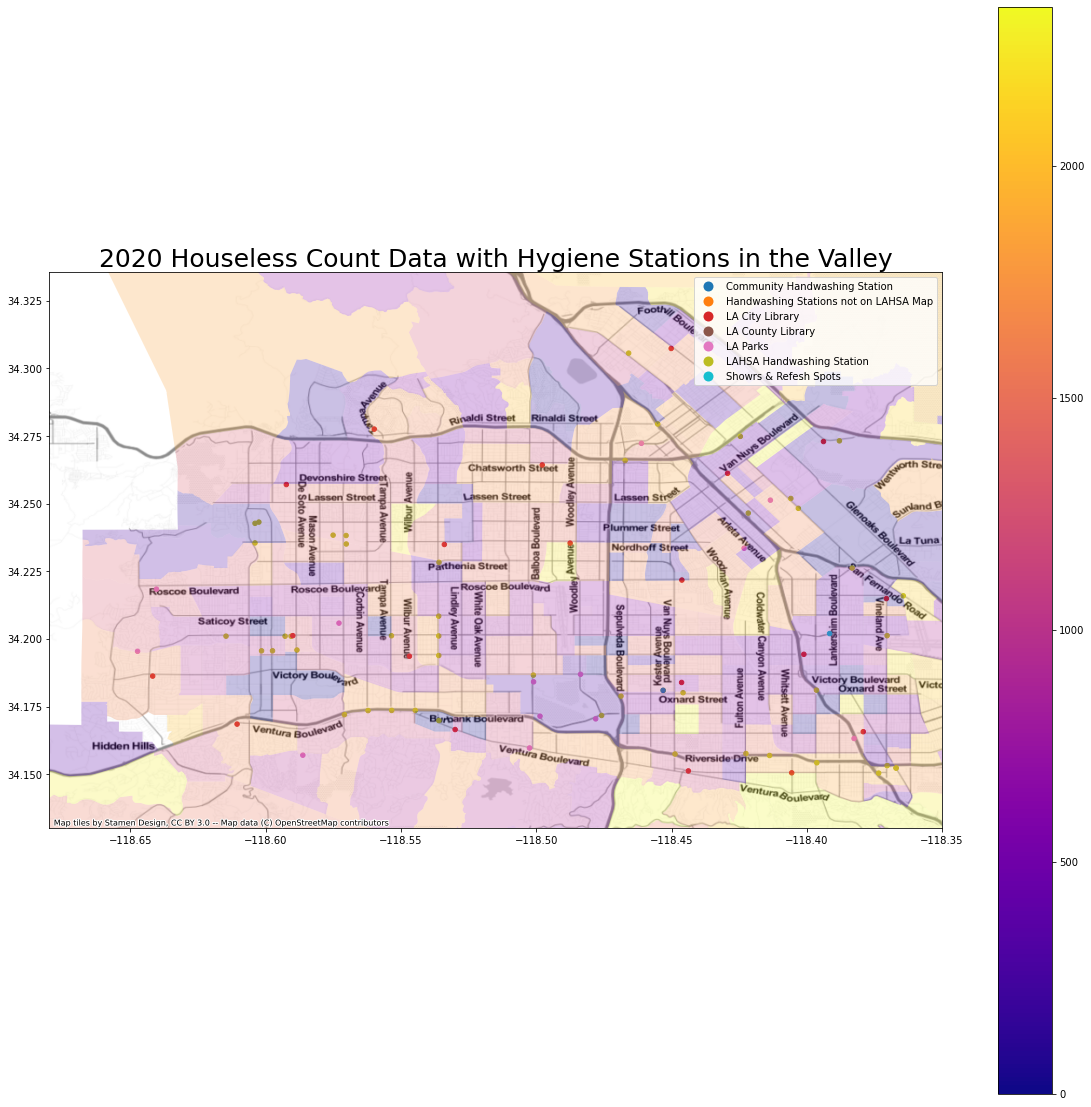

In [63]:
# Valley

f, ax = plt.subplots(figsize=(20,20))

toilets.plot('type', ax=ax, marker='o', markersize=20, legend=True)

counts.plot('homeless_count', 
            ax=ax, 
            cmap='plasma', 
            legend=True, 
            legend_kwds={'orientation': 'vertical'}, 
            alpha=0.25, 
            label='Count')
ax.set_xlim([-118.68, -118.35]) 
ax.set_ylim([34.13, 34.335567])
ax.set_title('2020 Houseless Count Data with Hygiene Stations in the Valley', fontsize=25)

ctx.add_basemap(ax,crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

plt.show()

Some text here with findings (WIP)